FTP 모델의 구분능력을 시각화하기 위해 FaultD 데이터셋에서 T-SNE 그리기

In [1]:
# 사전 변수
checkpoint_dir = "/home/hschoi/data/leehyunwon/ECG-SNN/ver7/faultD/1_hidden_128/filter_CNN_2D_faultD_2025-05-06-04-23-15_fold1_lastEpoch.pt"
config_json_dir = "/home/hschoi/data/leehyunwon/ECG-SNN/ver7/faultD/1_hidden_128/filter_CNN_2D_faultD_2025-05-06-04-23-15_fold1_config.json"

savefile_name = "FTP_FaultD_T-SNE.svg" # 일단 미정



In [2]:
# Imports
import os
import torch
import numpy as np # .npy 읽기용
import pandas as pd # csv 읽기용
import torch.nn.functional as F  # 일부 활성화 함수 등 파라미터 없는 함수에 사용
import torchvision.datasets as datasets  # 일반적인 데이터셋; 이거 아마 MIT-BIH로 바꿔야 할 듯?
import torchvision.transforms as transforms  # 데이터 증강을 위한 일종의 변형작업이라 함
from torch import optim  # SGD, Adam 등의 옵티마이저(그래디언트는 이쪽으로 가면 됩니다)
from torch.optim.lr_scheduler import CosineAnnealingLR # 코사인스케줄러(옵티마이저 보조용)
from torch import nn  # 모든 DNN 모델들
from torch.utils.data import (DataLoader, Dataset)  # 미니배치 등의 데이터셋 관리를 도와주는 녀석
from tqdm import tqdm  # 진행도 표시용
import torchmetrics # 평가지표 로깅용
from typing import Callable # 람다식
from torch.utils.tensorboard import SummaryWriter # tensorboard 기록용
import time # 텐서보드 폴더명에 쓸 시각정보 기록용
import random # 랜덤시드 고정용

# 여긴 인코더 넣을때 혹시 몰라서 집어넣었음
import sys
import os
import json
import numpy as np

import argparse

# 얘는 SNN 학습이니까 당연히 있어야겠지? 특히 SNN 모델을 따로 만드려는 경우엔 뉴런 말고도 넣을 것이 많다.
# import spikingjelly.activation_based as jelly
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer

from sklearn.model_selection import KFold # cross-validation용

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

2025-06-16 08:34:42.747422: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 08:34:42.798511: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-16 08:34:43.556597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# argparse 등의 config 분해용 코드
def load_json(path):
    with open(path) as data_file:
        param = json.load(data_file)

    return param

param = load_json(config_json_dir)
args = param

print(args)

{'config': '/home/hschoi/leehyunwon/ECG-SNN/new_server/ver7/IF/config/train/faultD/1_hidden_128/filter_CNN_config.json', 'device': {'gpu': '2', 'cuda': 'cuda'}, 'executor': {'type': 'trainer', 'args': {'random_seed': 999, 'k_folds': 5, 'num_epochs': 1000, 'early_stop_enable': False, 'early_stop_epoch': 25, 'optimizer': {'type': 'Adam', 'lr': 0.001}, 'scheduler': {'type': 'CosineAnnealingLR', 'args': {'T_max': 5, 'eta_min': 1e-05}}, 'checkpoint': {'active': True, 'path': '/home/hschoi/data/leehyunwon/ECG-SNN/ver7/faultD/1_hidden_128/'}}}, 'data_loader': {'type': 'faultD', 'args': {'batch_size': 256, 'num_workers': 8, 'train_path': '/home/hschoi/data/leehyunwon/time_series_FaultDetectionA/FaultDetectionA_TRAIN.ts', 'test_path': '/home/hschoi/data/leehyunwon/time_series_FaultDetectionA/FaultDetectionA_TEST.ts', 'dim': [1, 5120]}}, 'model': {'type': 'filter_CNN_2D', 'args': {'type_args': {'window': 128, 'stride': 64, 'padding': 0, 'channel': 1024}, 'input_channel': 1, 'hidden_size': 128, '

In [4]:
# cuda 환경 사용
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # GPU 번호별로 0번부터 나열
os.environ["CUDA_VISIBLE_DEVICES"]= str(args['device']['gpu'])  # 상황에 맞춰 변경할 것
device = "cuda" if torch.cuda.is_available() else "cpu" # 연산에 GPU 쓰도록 지정
print("Device :" + device) # 확인용

# 랜덤시드 고정
seed = args['executor']['args']['random_seed']
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Device :cuda


In [5]:
# FTP : 원래는 패키지에 따로 있지만 여기는 패키지 밖이므로 일단 따로 빼서 가져올 것
############################################ FTP 방식, 2D ############################################
class filter_CNN_2D(nn.Module):
    def __init__(self, num_classes, input_channel, hidden_size, hidden_size_2, out_channels, kernel_size, stride, padding, threshold_value, bias_option, reset_value_residual):
        super().__init__()
        
        # CNN 인코더 필터 : 이건 그냥 갈긴다.
        self.cnn_encoders = nn.Conv1d(in_channels=input_channel, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, padding=padding, bias=bias_option) # 여기도 bias가 있다 함
        
        # CNN 인코더 IF뉴런 : 이거 추가해서 인코더 완성하기
        self.cnn_IF_layer = neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value)
        
        # SNN 리니어 : 인코더 입력 -> 히든
        self.hidden = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(out_channels, hidden_size, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )
        
        # 레이어 1개로 줄이는 버전 다시 학습 필요
        # SNN 리니어 : 히든1 -> 히든2
        # self.hidden_2 = nn.Sequential(
        #     # layer.Flatten(),
        #     layer.Linear(hidden_size, hidden_size_2, bias=bias_option), # bias는 일단 기본값 True로 두기
        #     neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
        #     )

        # SNN 리니어 : 히든 -> 출력
        self.layer = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(hidden_size, num_classes, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

    def forward(self, x: torch.Tensor):
        results = 0. # for문이 모델 안에 있으므로 밖에다가는 이녀석을 내보내야 함
        
        # CNN 필터는 채널 차원이 추가되므로 1번 쪽에 채널 차원 추가 : 2D 방식에선 원래부터 2차원으로 입력되므로 필요없음
        #x = x.unsqueeze(1)

        # CNN 필터 통과시키기
        x = self.cnn_encoders(x) # [배치, 출력채널(기본 1024), 새로운 timestep] 형태가 될 것임
        # print(x.shape)
        timestep_size = x.shape[2]
        # 근데 이제 이렇게 바꾼 데이터는 (배치, 채널, 출력크기) 만큼의 값을 갖고 있으니 여기서 나온 값들을 하나씩 잘라서 다음 레이어로 넘겨야 한다.
        for i in range(timestep_size) : 
            x_slice = x[:,:,i].squeeze() # 이러면 출력크기 차원이 사라지고 (배치, 채널)만 남겠지?
            x_slice = self.cnn_IF_layer(x_slice) # CNN 필터 이후 IF 레이어 거치기
            x_slice = self.hidden(x_slice)
            # x_slice = self.hidden_2(x_slice)
            x_slice = self.layer(x_slice)
            results += x_slice  # 결과를 리스트에 저장(출력발화값은 전부 더하는 식으로)
        # results = torch.stack(results, dim=0) # 텐서로 바꾸기
        return results / timestep_size

In [6]:
# 모델 불러다가 .pt에 맞춰서 넣기 : 일단 FordA 데이터셋으로 학습된 모델을 쓰지만, 데이터로더는 여기선 필요없음

# 임시 : args 변경
args_original = args
args = args['model']

# SNN 네트워크 초기화
model = filter_CNN_2D(num_classes = args['args']['num_classes'],  input_channel=args['args']['input_channel'], hidden_size=args['args']['hidden_size'], hidden_size_2=None, 
                                out_channels=args['args']['type_args']['channel'], kernel_size=args['args']['type_args']['window'], 
                                stride=args['args']['type_args']['stride'], padding=args['args']['type_args']['padding'], 
                                threshold_value=args['args']['threshold'], bias_option=args['args']['need_bias'], 
                                reset_value_residual=args['args']['reset_value_residual']).to(device=device)

# args 원복
args = args_original

# 모델 로드 함수 정의
def load_model(checkpoint_path_, model):
    checkpoint = torch.load(checkpoint_path_)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # 평가 모드로 전환
    return model


# 모델에 가중치 넣기
model = load_model(checkpoint_dir, model)

In [7]:
# 데이터로더 작업

# faultD Loader
class FaultD_Loader(Dataset):
    def __init__(self, ts_file_path):
        self.data = []
        self.labels = []

        with open(ts_file_path, 'r') as f:
            lines = f.readlines()

        # @data 이후부터 유효한 데이터
        data_start_idx = next(i for i, line in enumerate(lines) if line.strip().lower() == "@data") + 1
        data_lines = [line.strip() for line in lines[data_start_idx:] if line.strip()]

        for line in data_lines:
            if ':' not in line:
                continue

            signal_str, label_str = line.rsplit(':', 1)
            signal = np.array([float(x) for x in signal_str.split(',')], dtype=np.float32)

            # 0~1 정규화 (데이터포인트 단위)
            min_val, max_val = np.min(signal), np.max(signal)
            if max_val - min_val > 0:
                signal = (signal - min_val) / (max_val - min_val)
            else:
                signal = np.zeros_like(signal)

            label = int(label_str.strip())

            self.data.append(torch.tensor(signal))  # shape: [5120]
            self.labels.append(label)               # int: 0, 1, 2

        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], idx
    

batch_size = 256
dataset = FaultD_Loader(ts_file_path=args['data_loader']['args']['train_path'])
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last = True)

In [8]:
# T-SNE 시작

def compute_spike_rate_with_indices(model, data_loader, device):
    spike_rates = []
    labels = []
    indices = []

    model.eval()

    current_idx = 0

    # # FTP는 timestep을 직접 계산해야 함
    # functional.reset_net(model)
    # inputs = next(iter(data_loader))[0].unsqueeze(1).to(device) # unsqueeze가 없으면 1차원짜리 채널이 없는 판정이 돼서 conv1d가 작동하지 않음
    # print(inputs.shape)
    # d = model.cnn_encoders(inputs)  # CNN 인코더의 출력 크기에서 시퀀스 길이 추출
    # print(d.shape)
    # seq_len = d.shape[2]  # CNN 인코더의 출력 크기에서 시퀀스 길이 추출
    with torch.no_grad():
        for data, target, idx in data_loader:
            functional.reset_net(model)
            data = data.to(device)
            target = target.to(device)

            # spike_rate = model(data.unsqueeze(1))  # 모델에 데이터 통과시키기

            # IF 레이어까지만 통과
            # CNN 필터 통과시키기
            results = 0.
            x = model.cnn_encoders(data.unsqueeze(1)) # [배치, 출력채널(기본 1024), 새로운 timestep] 형태가 될 것임
            # print(x.shape)
            timestep_size = x.shape[2]
            # 근데 이제 이렇게 바꾼 데이터는 (배치, 채널, 출력크기) 만큼의 값을 갖고 있으니 여기서 나온 값들을 하나씩 잘라서 다음 레이어로 넘겨야 한다.
            for i in range(timestep_size) : 
                x_slice = x[:,:,i].squeeze() # 이러면 출력크기 차원이 사라지고 (배치, 채널)만 남겠지?
                x_slice = model.cnn_IF_layer(x_slice) # CNN 필터 이후 IF 레이어 거치기
                results += x_slice  # 결과를 리스트에 저장(출력발화값은 전부 더하는 식으로)

            results /= timestep_size  # 평균내기

            # for i in range(seq_len):
            #     x_slice = data[:, i].unsqueeze(1)
            #     spikes = model.encoder(x_slice)
            #     spikes = model.hidden(spikes)
            #     spikes = model.layer(spikes)
            #     spike_sum += spikes

            # spike_rate = spike_sum / seq_len
            spike_rates.append(results.cpu().numpy())
            labels.append(target.cpu().numpy())
            indices.append(idx.numpy())  # 데이터 순번 저장

    spike_rates = np.concatenate(spike_rates, axis=0)
    labels = np.concatenate(labels, axis=0)
    indices = np.concatenate(indices, axis=0)

    return spike_rates, labels, indices


# spike_rates, labels, indices 가져오기
spike_rates, labels, indices = compute_spike_rate_with_indices(model, data_loader, device)


tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(spike_rates)  # shape: (전체 데이터 수, 2)

# tsne_result: 각 데이터의 2D 좌표
# labels: 각 데이터의 라벨
# indices: 각 데이터의 데이터포인트 번호

/tmp/ipykernel_2642758/3302245167.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels))  # discrete colormap


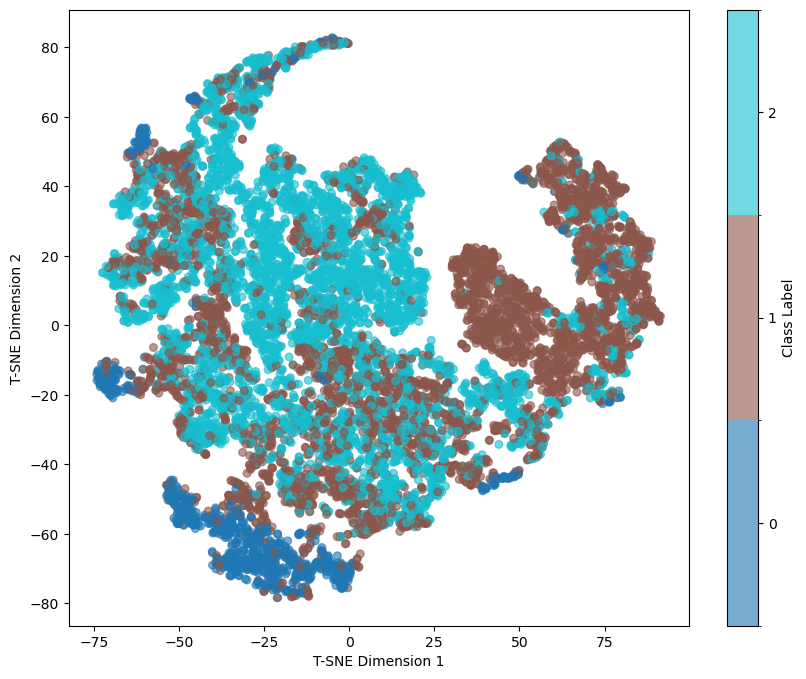

In [9]:
# T-SNE 시각화 함수 정의 및 사용
from matplotlib.colors import BoundaryNorm

def plot_tsne_discrete(tsne_result, labels):
    plt.figure(figsize=(10, 8))

    unique_labels = np.unique(labels)
    cmap = plt.cm.get_cmap('tab10', len(unique_labels))  # discrete colormap
    norm = BoundaryNorm(boundaries=np.arange(-0.5, len(unique_labels)+0.5, 1), ncolors=len(unique_labels))

    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.6, s=30)

    cbar = plt.colorbar(scatter, ticks=unique_labels)
    cbar.set_label('Class Label')

    # plt.title('T-SNE Visualization of SNN Encoder Outputs')
    plt.xlabel('T-SNE Dimension 1')
    plt.ylabel('T-SNE Dimension 2')
    plt.grid(False)
    plt.savefig(savefile_name, format='svg', dpi=300)  # SVG로 저장
    plt.show()

# spike_rates, labels, indices: compute_spike_rate_with_indices()에서 반환
plot_tsne_discrete(tsne_result, labels)

In [10]:
# silhouette_score 계산
silhouette_avg = silhouette_score(tsne_result, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

silhouette_avg = silhouette_score(spike_rates, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.0539
Silhouette Score: 0.0051


In [13]:
# 쿼리 포인트를 통해 가장 가까운 데이터포인트 번호 찾기

query_point = np.array([-40, -60])
distances = np.linalg.norm(tsne_result - query_point, axis=1)
closest_idx = np.argmin(distances)
data_point_number = indices[closest_idx]

print(f"해당 점의 데이터포인트 번호는: {data_point_number}")

해당 점의 데이터포인트 번호는: 1403
